In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

In [2]:
df_train = pd.read_csv("../data/interim/train_no_dup.csv", index_col=0)
df_train = df_train.reset_index()

In [3]:
df_train.shape

(35631, 4)

In [4]:
df_train

,index,oid,category,text
0,0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...,...
35626,38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
35627,38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
35628,38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
35629,38738,776944963,volleyball,Стал известен календарь мужской сборной России...


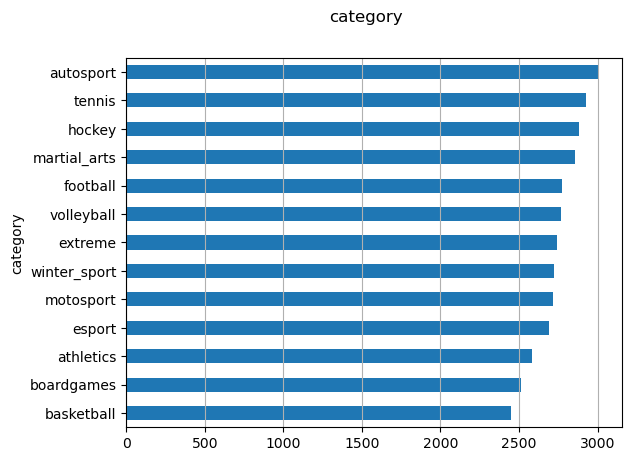

In [5]:
fig, ax = plt.subplots()
fig.suptitle("category", fontsize=12)
df_bar = df_train["category"].reset_index().groupby("category").count().sort_values(by="index")
df_bar.plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

Разница между самой многочесленной категорией и категорией с самым малым кол-вом объектов всего ~16%. Поэтому выборка можно считать слабо несбалансированной. Для построения безлайн модели можно обойтись без down-up-sampling методов. Однаком может понадобиться некоторая балансировка вероятностей и за целевую метрику лучше принять метрики устойчивые к дисбалансам классов: precision, recall, f1-score.

# I. Поиск особенностей в тренировочной выборке

Посмотрим все объекты с oid 473121466.

In [6]:
df_train[df_train.oid == 473121466]

,index,oid,category,text
42,42,473121466,volleyball,hq от подписчика каверопенинга Вашему вниманию...
10076,10535,473121466,volleyball,hq от подписчика хочу снова поделиться рисуноч...
16970,17926,473121466,volleyball,hq Сама решила сделать картиночки если надо ск...
21424,22757,473121466,volleyball,hq день почти подошел к концу в моем городе а ...


#### Выглядит как подписи к постам в инстаграм. Не ясна почему добавлена метка volleyball
#### Повторяется мусорное hq, посмотрим где еще в трейне в тексте содержиться hq?

    -> в основном в метках volleyball
    -> многие записи выглядят как комментарии, некоторые как реклама

In [7]:
for text in df_train[df_train.text.apply(lambda x: "hq" in x)].text.values:
    print('-', text[:200])

- Rtokenoid Warhammer40k валрак решил нас подкормить не сильно свежими слухами а именно составом новой коробки грядущего обновления Имперской Гвардии. Слух практически идентичен августовский информации 
- hq от подписчика каверопенинга Вашему вниманию лучший на мой взгляд кавер от подписчика 33 Кавер на Hatokenoid 33 33 Season 4 от команды MUSEN
- hq от подписчика Хэ скоро в школу Админ не доводи людей до депрессии
- hq Капец мне сегодня исполнилось 15 лет. С днем рождения меня ️ ️
- hq вот и все ребят спасибо что были со мной в этот день
- hq Нашла классного бота с Кенмой tokentokenoid Покидайте ботов других персонажей?
- hq от подписчика Аэа просто хотела поделиться любимцами
- hq Если ваша вечеринка не похожа на вот это вот все то не зовите меня
- hq Привет ребятки мои любимые я один из редакторов этого паблика вы видите мое имя почти под каждым постом МНЕ НАКОНЕЦ ТО ИСПОЛНИЛОСЬ 16 трутутутуту существую тут уже года три кстати сменилось много р
- hq от подписчика можно я тут поделюс

### Посмотрим что входит в категорию volleyball

In [55]:
for text in df_train[df_train.category == "volleyball"][:20].text.values:
    print('-', text[:200])

- Последний день заявочной кампании на Финал Чемпионата России по волейболу на снегу 31 марта 2 апреля на горнолыжном курорте Шерегеш в Кемеровской области закрываем сезон Бонус призовой фонд увеличен П
- МНЕ ЗАПРЕТИЛИ ИГРАТЬ С КАМЕРОЙ? Жирный профи НЕ притворился новичком
- Болл – старший тренер Урала ️ Бывший волейболист Урала и казанского Зенита Ллой Болл вошел в тренерский штаб Урала. Он будет помогать Юрию Лисицкому и Владиславу Макарову в конце чемпионата. Соглашени
- hq от подписчика каверопенинга Вашему вниманию лучший на мой взгляд кавер от подписчика 33 Кавер на Hatokenoid 33 33 Season 4 от команды MUSEN
- Результаты матчей второго игрового дня 29 июня третей игровой недели женской Лиги наций 2022 Калгари Группа 5 Япония Нидерланды 2 3 25 23 20 25 26 24 21 25 10 15 Бельгия США 0 3 16 25 21 25 19 25 Софи
- Завершаем пляжный марафон в Анапе Смотри все решающие встречи BetBoom этапа Чемпионата России на Матч Страна и ТВ Старт
- К сожалению в это сезоне Кубок ЕКВ нам не подарит р

> Первые 20 сэмплов категории воллейбол, показывают, что к этой категории и правда принадлежат выписки из новостей о воллейболе, скорее всего объекты с oid == 473121466 - это выбросы

> Заметим, что кроме выбросов присутсвуют объекты, чью категорию сложно определить: `'Лига чемпионов 2022 2023. Мужчины Кнак Тур Расписание матчей турнирные таблицы'`.
Этот пример может приниадлежать любой из категорий (лига чемпионов, турнирные таблицы и т.д могу принадлежать любому виду спорта): tennis, hockey, volleyball, football, basketball, ...
Если Кнак Тур - это не часто повторяющееся название воллейбольных турниров, тогда будет невозможно однозначно определить категорию этого объекта.

#### Еще один интересный oid  (рекламные посты) и tokenid

In [52]:
for text in df_train[df_train.oid == 753904581].text.values:
    print('-', text[:100])

- Ломаете голову над подарком для коллеги или друга а времени остается совсем немного? 33 ⠀ Нет лучше 
- КАК ПОДОБРАТЬ СЕБЕ ШЛЕМ по размеру какие нюансы при выборе шлема влияют на его размер узнаем в этом 
- Впереди столько праздников 33 И перед каждым встает задача выбрать достойный подарок для близких люд
- Готовимся к зимним покатушкам с брендом Atokenoid. ⠀⠀ Покрытие устойчивое к механическим повреждения
- Бренд SHIMA Шима Польша существует с 2009 года. ⠀ На данный момент экипировка этой марки продается в
- Компания HYPERLOOK в 2011 году первой запустила производство мотоэкипировки на территории Российской
- Спортивные перчатки из козьей кожи и текстиля. ⠀ Легкая внутренняя тканевая подкладка Ладонь из кожи
- Stokenoid EXO 930 SOLID это шлем модуляр созданный по запросу пользователей предыдущей модели EXO 90
- Компания основана в Канаде стране где лучше всего знают каким должен быть шлем для снегохода. ⠀ Осно
- Поздравляем С Днем Защитника Отечества 33 ⠀ Желаем мирного неба над гол

### Гипотезы:
- tokentokenoid - маска для url сайта ?
- motoektokenoid - маска для определенного мото сайта ?

### Категория - martial_arts

In [60]:
for text in df_train[df_train.category =="martial_arts"][2700:2720].text.values:
    print('-', text[:100])

- Майк Тайсон переоценен и не смог бы победить в бою с сегодняшними гигантами?
- КУДО В БОЛГАРИИ Чемпионат и Первенство Болгарии по кудо от 1 мая 2022 года
- КОНКУРС УГАДАЙКА десять айфонов и ГЛАВНЫЙ ПРИЗ ЛЯГУШОНОК. Удачи друг смотри ниже там больше инфы ВСЕ
- Смотреть Полный Бой ПОРЬЕ vs ЧЕНДЛЕР. Прямой Эфир UFC 281
- Майкл Биспинг оценил шансы Грина в бою с Махачевым Экс чемпион UFC в среднем весе Майкл Биспинг дал 
- Этот день в истории Ровно 98 лет тому назад на первомайскую демонстрацию вышли боксеры рабочего союз
- Обучающие видео Удар с разворота в корпус соперника Удары локтями в гарде оппонента Удар ногой по пе
- Крутейшее видео Скоро выйдет вторая часть а эту просмотрел на одном дыхании Atokenoid StevenSeagal С
- Коди Стэменн побеждает Эдди Вайнлэнду техническим нокаутом в первом раунде 33
- ПРАВИЛА ФОТОГРАФИРОВАНИЯ С СЕНСЕЕМ Автор Lee Attey Перевод Татьяна Тропина 27 февраля 2014 В каждой 
- ПОДПИСЫВАЙТЕСЬ 33 Все самое лучшее у нас в группе 33 Паблик посвящен лучшему бойцу с

> Новости спорта перемешаны с рекламой.

Еще интересное из данной категории:

* 'Уязвимые точки тела Теория уязвимых точек проистекает из многовековой практики мастеров акупунктуры чжэнь цзю терапии. Суть ее вкратце сводится к тому что в теле человека заключены 12 жизненно важных органов сердце печень легкие и т. д соответствующих знакам Зодиака. Нервные окончания связывают каждый из этих органов с несколькими десятками точек разбросанных по всему телу. Воздействие на них приводит к воздействию на сам орган.'
* 'Интересное с Atokenoid полезная группа Заходи скорее tokenoidtokenoid',
* Кристин Фереа vs. Тайлор Старлинг. Чемпионский бой. BKFC 28.',
* 'Конкурентов не нужно опасаться. Пользуйтесь их опытом и учитесь на их ошибках чтобы сделать ваш продукт уникальным.',
* 'Наши достижения всегда соответствуют нашим амбициям. Андрей Курпатов'

### Category - martial_arts, esport-> много мусорных объектов (реклама, комментарии)

### Сколько oid входят в каждую из категорий?

In [17]:
df_train.groupby(["category"]).apply(lambda x: len(x.oid.unique()))

category
athletics       297
autosport       316
basketball      285
boardgames      302
esport          299
extreme         311
football        286
hockey          295
martial_arts    305
motosport       303
tennis          300
volleyball      295
winter_sport    280
dtype: int64

Каждая категория содержит примерно одинаковое колличество различных oid.

### Заключение № 1

1. Представлен набор текстов из различных сайтов.
2. Каждому тексту присвоена категория.
3. Все тексты можно также разделить на 3 группы: новостные посты, реклама, комментарии, комментарии в блоге.
4. Данные очень шумные, в некоторых категориях нельзя различить реальной зависимости.
5. Были найдены некоторые маски (скорее всего замаскированные ссылки): nvtokenoid, tokentokenoid, ...
6. В текст входят различные английские токены, что может быть хорошим признаком того, что текст является рекламой. Однаком здесь требуется дополнительный анализ.

# II. Определение значимости tokenid токенов

In [18]:
def get_eng(row):
    
    tmp = re.sub(r'[^a-zA-Z]+( |)', ' ', row)
    tmp = tmp.strip().lower()
    return tmp

eng_texts = df_train.text.apply(lambda x:get_eng(x)).values
eng_texts = [x for x in eng_texts if x]

In [19]:
len(eng_texts)

19062

In [20]:
eng_tokens = " ".join(eng_texts).split(" ")
eng_tokens = [x for x in eng_tokens if len(x) > 2]

In [21]:
eng_tokens_index, eng_counts = np.unique(eng_tokens, return_counts=True,)
count_sort_ind = np.argsort(-eng_counts)

### Top 100  токенов в текстах

In [22]:
eng_tokens_index[count_sort_ind][:100]

array(['tokentokenoid', 'rtokenoid', 'tokenoidtokenoid', 'tokenoid',
       'motogp', 'atokenoid', 'stokenoid', 'tetokenoid', 'ratokenoid',
       'hotokenoid', 'ftokenoid', 'btokenoid', 'ufc', 'dtokenoid',
       'mtokenoid', 'open', 'motoektokenoid', 'speetokenoid',
       'votokenoid', 'ntokenoid', 'sport', 'red', 'ctokenoid', 'wta',
       'the', 'newstokentokenoid', 'atp', 'wortokenoid', 'team',
       'ferrari', 'news', 'hontokenoid', 'ptokenoid', 'wtokenoid',
       'yamaha', 'yotokenoid', 'ltokenoid', 'ktokenoid', 'lamppost',
       'moto', 'mertokenoid', 'qtokenoid', 'etokenoid', 'pro',
       'vtokenoid', 'ttokenoid', 'warhammer', 'gtokenoid', 'drtokenoid',
       'fia', 'nba', 'parkrtokenoid', 'komtokenoid', 'utokenoid', 'tcr',
       'htokenoid', 'otokenoid', 'aprtokenoid', 'gotokenoid',
       'nvtokenoid', 'ktm', 'matokenoid', 'formtokenoid', 'fatokenoid',
       'hetokenoid', 'metokenoid', 'tratokenoid', 'sports', 'games',
       'motorsport', 'whtokenoid', 'twtokenoid',

In [23]:
eng_counts[count_sort_ind][:100]

array([4458, 2692, 2637, 2580, 1520, 1130, 1125,  989,  930,  899,  867,
        837,  789,  715,  707,  594,  555,  520,  515,  481,  480,  473,
        467,  467,  437,  425,  412,  406,  401,  401,  390,  378,  374,
        363,  356,  343,  340,  318,  311,  303,  303,  299,  288,  275,
        255,  251,  246,  242,  222,  215,  211,  209,  209,  188,  188,
        186,  183,  181,  180,  171,  169,  169,  169,  169,  164,  160,
        157,  137,  137,  135,  132,  130,  123,  122,  121,  119,  117,
        117,  116,  116,  115,  115,  114,  110,  109,  106,  104,  104,
        104,  102,  101,  100,   98,   98,   98,   97,   96,   96,   96,
         96])

In [24]:
TOKEN_IDS = [x for x in eng_tokens_index if x.endswith("id")]

In [25]:
len(TOKEN_IDS)

1739

In [27]:
len(df_train.oid.unique())

3874

### Заключение №2

1. В текстах замаскированы скорее всего ссылки на сайты в виде site_name+tokenid (далее будет называть их tokenid)
2. Различных oid больше чем различных tokenid
3. Гипотеза: tokenid может быть также эмоджи.
4. Уникальных tokenid слишком много, чтобы выделить их в отдельный признак-категорию. Поэтому при подготовке данных, очистим поле text от tokenid.
5. Возможно tokenid может быть хорошим признаком, но здесь нужна дополнительная информация: постановка бизнес задачи и информация о сборе данных. Для построения бейзлайна, будет достаточно принять гипотезу что tokenid - это замаскированная ссылка и во избежании переобучения ее стоит убрать из текста.

# III. Просмотр всех категорий

In [30]:
for cat in df_train.category.unique():
    print("-------------------------------------", cat.upper(), "-------------------------------------")
    
    print(df_train[df_train.category == cat].text.values[:10])

------------------------------------- WINTER_SPORT -------------------------------------
['Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid'
 'Для ребят из Курска и ближайших городов может кому интересно Серебряный призер Олимпийских Игр в Пекине в смешанной команде Евгений Климов посетит спортивный городок в Курске на театральной площади Курские известияtokenoid Курска В Курске 26 июня перед Драмтеатром поставят спортивный городок Курск станет главным городом празднования Всероссийского Олимпийского дня в стране. Праздничную площадку организуют на Театральной площади и стадионе Трудовые резервы. Перед драмтеатром появится городок с экспозициями разных видов спорта срди прочих покажут керлинг прыжки на лыжах бобслей санный спорт пятиборье. На Трудовых резервах пройдут соревнования по баскетболу 3х3 мини футболу лапте легкой атлетике тэг регби также здесь разместятся выставки конного спорта и стрельбы из лука. План мероприятий и другие вопросы на совещании с представите